In [1160]:
import pandas as pd
import numpy as np

import time
import string
import random

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymorphy2

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import svm

import xgboost as xgb

In [974]:
FIG_SIZE = (15, 6)

IS_PROTOTYPING = True
PROTOTYPE_SIZE = 1000

In [1659]:
#убираем шаблоны: веб-ссылки, ссылка на автора при ответе.
def replace_answer(msg):
    return ' '.join(filter(lambda x:x[0]!='@' and not x.startswith('http'), msg.split()))

#нормализуем и преобразуем хештег в слово (опционально)
morph = pymorphy2.MorphAnalyzer()
def normal_form(word, remove_hashtag = False):
    if remove_hashtag and word.startswith('#'):
        word = word[1:]
        
    return morph.parse(word)[0].normal_form

#почему-то нет некоторых знаков пунктуации и части стоп-слов
custom_stops = [u'...', u'ещё', u'это', u'весь', u'..', u'—', u'я', u'и', u'a', u'\u2026', u'RT', 'RT']
stop = set(stopwords.words('russian') + list(string.punctuation) + custom_stops + list(string.digits))
def remove_stop_words(words):
    return [w for w in words if w not in stop]

USE_NORMAL_FORM = True
tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return tknzr.tokenize(msg)

In [1193]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

# оставляем только класс и сам текст сообщения
# TODO: зависит ли тональность от отправителя? (кто-то склонен к грусти, кто-то к радости)
# Или времени суток/времени года (летом радость, осенью грусть)?
neg = neg.drop(['id', 'tdate', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'tdate', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos['ttext'] = pos['ttext'].apply(replace_answer)
neg['ttext'] = neg['ttext'].apply(replace_answer)

In [1197]:
def test_models(sizes, models, n_gramms_max = 1, debug_out = False):
    ret = dict()
    
    for n_gramm in range(1, n_gramms_max + 1):
        scores = {m[0]: [] for m in models}

        vectorizer = TfidfVectorizer(min_df = 3, ngram_range= (1, n_gramm),
                                     stop_words = stop, tokenizer = tweet_tokenize)

        for s in sizes:
            X = pd.concat([pos[:s], neg[:s]])

            y = np.array(X['ttype'])
            X_tweets = np.array(X['ttext'])
            
            if debug_out:
                print 'starting process %d tweets' % (s*2)                

            for m in models:
                pipe = Pipeline( [('vect', vectorizer), ('model', m[1])])
                cv_score = np.mean(cross_val_score(pipe, X_tweets, y, cv = 5, n_jobs = 5))

                scores[m[0]].append(cv_score) 

        plt.figure(figsize=FIG_SIZE)

        for m in scores:
            plt.plot(sizes, scores[m], label = m)
            
            if debug_out:
                print m, scores[m]
        
        ret[n_gramm] = scores
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad = 0.)
        plt.title('n-gramms: %d' % n_gramm)
        
    return ret
    

starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
Linear SVC [0.78150000000000008, 0.77699999999999991, 0.79359999999999997]
XGB [0.77699999999999991, 0.77249999999999996, 0.78590000000000004]
bayes [0.75700000000000001, 0.78075000000000006, 0.80130000000000001]
Non-linear SVC [0.78599999999999992, 0.79500000000000004, 0.80159999999999998]
starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
Linear SVC [0.78149999999999997, 0.77949999999999997, 0.79109999999999991]
XGB [0.77449999999999997, 0.77274999999999994, 0.78510000000000013]
bayes [0.75600000000000001, 0.78125000000000011, 0.79930000000000001]
Non-linear SVC [0.78700000000000003, 0.7965000000000001, 0.80009999999999992]
starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
Linear SVC [0.78200000000000003, 0.78000000000000003, 0.79149999999999987]
XGB [0.77500000000000002, 0.77450000000000008, 0.78680000000000005]
bayes [0.7

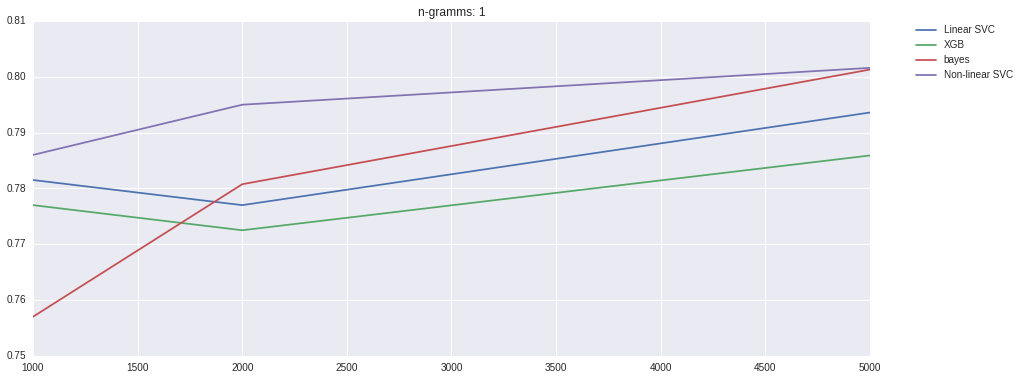

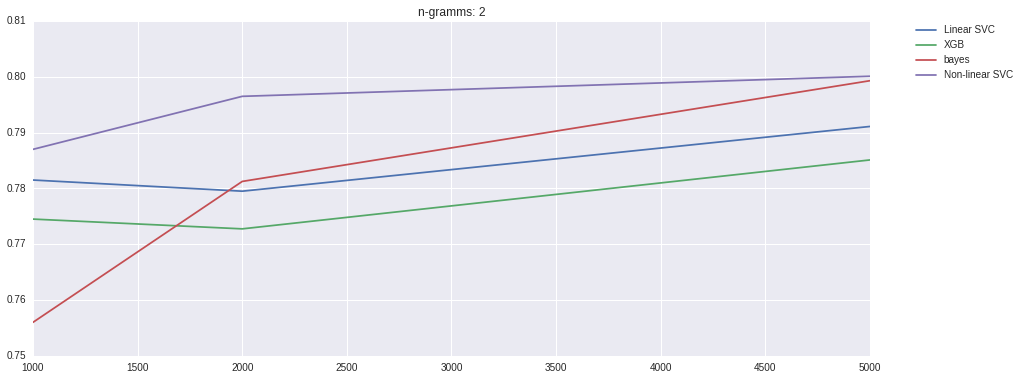

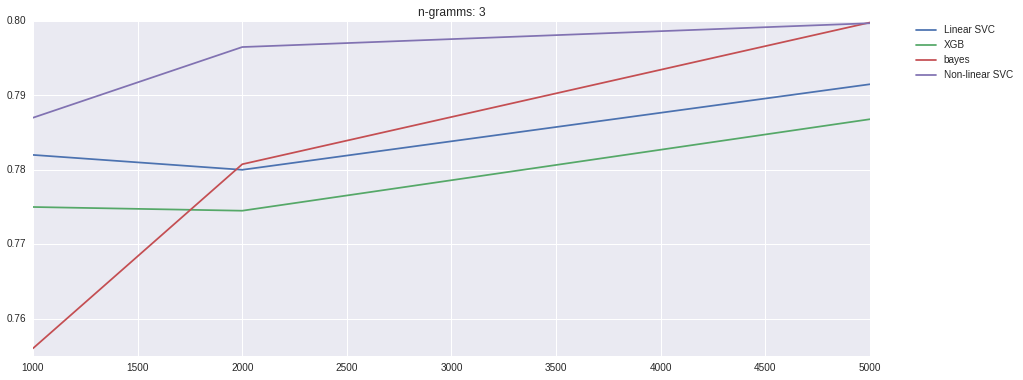

In [1199]:
models_to_test = [
    ('bayes', naive_bayes.MultinomialNB()),
    ('XGB', xgb.XGBClassifier(n_estimators=1200, max_depth=5, learning_rate=0.02)),
    ('Linear SVC', svm.LinearSVC()),
    ('Non-linear SVC', svm.SVC(gamma=0.1))
]

# В оригинальном датасете около 111.000 сообщений каждого класса. 
# Слишком долго работать со всеми при прототипировании
sizes_to_test = [1000, 2000, 5000, 10000, 25000, 50000]

USE_NORMAL_FORM = False
scores = test_models(sizes_to_test, models_to_test, n_gramms_max = 3, debug_out=True)

starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
Linear SVC [0.75449999999999995, 0.77224999999999999, 0.79630000000000012]
XGB [0.77500000000000002, 0.76700000000000002, 0.78600000000000003]
bayes [0.77100000000000002, 0.77299999999999991, 0.80090000000000006]
Non-linear SVC [0.78550000000000009, 0.79350000000000009, 0.80459999999999998]
starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
Linear SVC [0.75650000000000006, 0.77100000000000002, 0.79739999999999989]
XGB [0.77399999999999991, 0.77049999999999996, 0.78559999999999997]
bayes [0.77150000000000007, 0.77549999999999997, 0.80269999999999997]
Non-linear SVC [0.78649999999999998, 0.79374999999999996, 0.8054]
starting process 2000 tweets
starting process 4000 tweets
starting process 10000 tweets
Linear SVC [0.75700000000000001, 0.77100000000000013, 0.79749999999999999]
XGB [0.77500000000000002, 0.77100000000000002, 0.78599999999999992]
bayes [0.7710000000000

{1: {'Linear SVC': [0.75449999999999995,
   0.77224999999999999,
   0.79630000000000012],
  'Non-linear SVC': [0.78550000000000009,
   0.79350000000000009,
   0.80459999999999998],
  'XGB': [0.77500000000000002, 0.76700000000000002, 0.78600000000000003],
  'bayes': [0.77100000000000002, 0.77299999999999991, 0.80090000000000006]},
 2: {'Linear SVC': [0.75650000000000006,
   0.77100000000000002,
   0.79739999999999989],
  'Non-linear SVC': [0.78649999999999998, 0.79374999999999996, 0.8054],
  'XGB': [0.77399999999999991, 0.77049999999999996, 0.78559999999999997],
  'bayes': [0.77150000000000007, 0.77549999999999997, 0.80269999999999997]},
 3: {'Linear SVC': [0.75700000000000001,
   0.77100000000000013,
   0.79749999999999999],
  'Non-linear SVC': [0.78550000000000009, 0.79374999999999996, 0.8044],
  'XGB': [0.77500000000000002, 0.77100000000000002, 0.78599999999999992],
  'bayes': [0.77100000000000013, 0.77549999999999997, 0.80269999999999997]}}

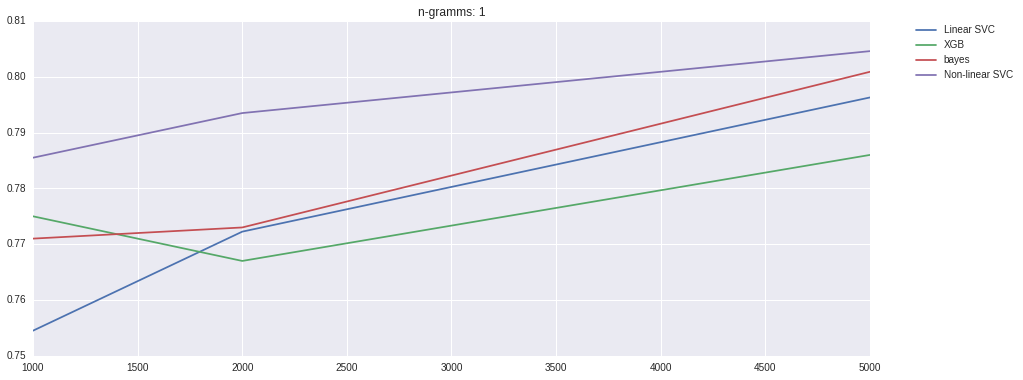

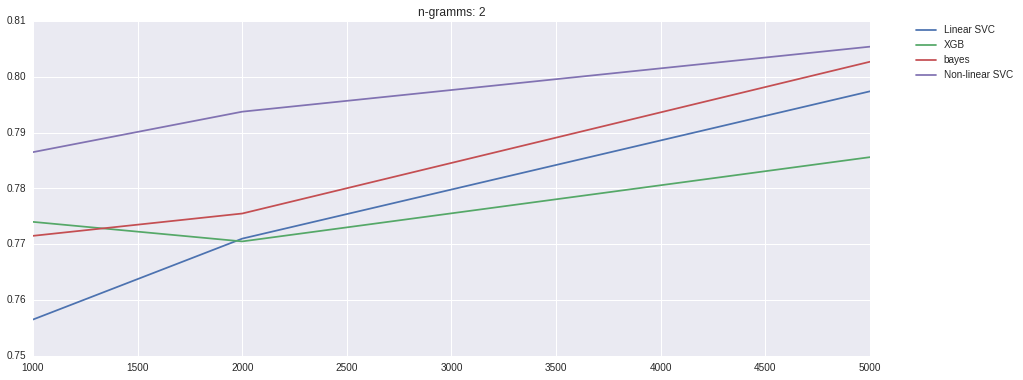

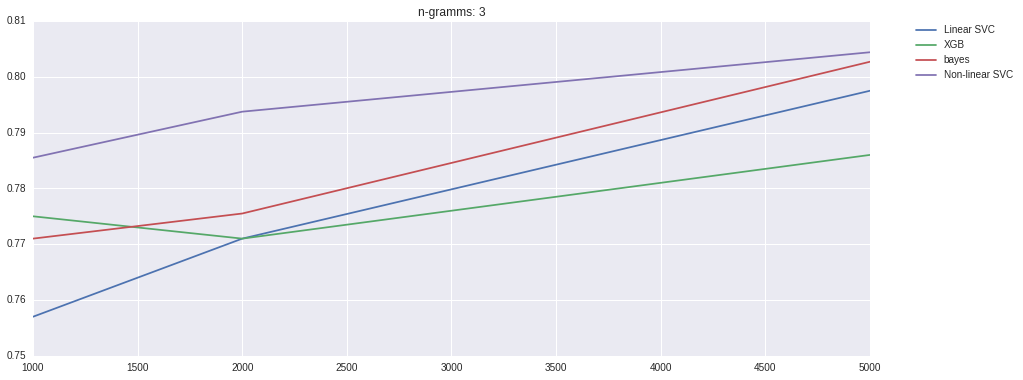

In [1200]:
USE_NORMAL_FORM = True
scores = test_models(sizes_to_test, models_to_test, n_gramms_max = 3, debug_out=True)

In [1061]:
X_tweets = list(pos['ttext'][:PROTOTYPE_SIZE])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

pos_words = words_counts[-15:]

X_tweets = list(neg['ttext'][:PROTOTYPE_SIZE])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

neg_words = words_counts[-15:]

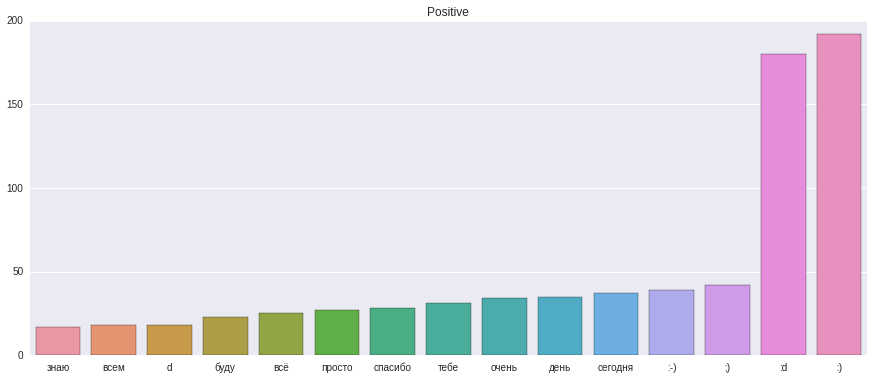

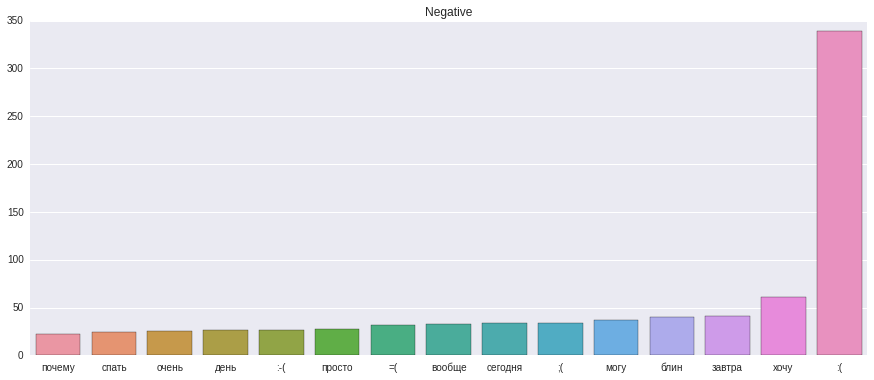

In [1062]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
sns.plt.title('Positive')

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in neg_words], y=[w[1] for w in neg_words])
sns.plt.title('Negative')

In [936]:
from pybrain.datasets import ClassificationDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer, TanhLayer
from pybrain.utilities import percentError

In [903]:
HIDDEN_NEURONS_NUM = 100 
MAX_EPOCHS = 100

In [904]:
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [905]:
ds_train = ClassificationDataSet(X_train_vec.shape[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', X_train_vec)
ds_train.setField('target', y_train[:, np.newaxis]) 
ds_train._convertToOneOfMany( ) 

ds_test = ClassificationDataSet(X_test_vec.shape[1], nb_classes=len(np.unique(y_test)))
ds_test.setField('input', X_test_vec)
ds_test.setField('target',  y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

In [938]:
np.random.seed(0)

for nn in range(100, 1000, 100):
    print 'neurons num: %d' % nn
    net = buildNetwork(ds_train.indim, nn, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass=TanhLayer)

    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)

    trainer = BackpropTrainer(net, dataset = ds_train) 
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs = 10)

    res_train = net.activateOnDataset(ds_train).argmax(axis=1) # Подсчет результата на обучающей выборке
    print 'Error on train: ', percentError(res_train, ds_train['class']), '%' # Подсчет ошибки
    res_test = net.activateOnDataset(ds_test).argmax(axis=1) # Подсчет результата на тестовой выборке
    print 'Error on test: ', percentError(res_test, ds_test['class']), '%' # Подсчет ошибки
    print '********'

neurons num: 100
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 200
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 300
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 400
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 500
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 600
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 700
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 800
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********
neurons num: 900
Error on train:  50.5714285714 %
Error on test:  48.6666666667 %
********


In [1664]:
import datetime

In [1677]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['id', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos['ttext'] = pos['ttext'].apply(replace_answer)
neg['ttext'] = neg['ttext'].apply(replace_answer)

In [1678]:
def convert_date(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    h = date.hour
    
#     if h <= 6:
#         d_type = 'Night'
#     elif h <= 12:
#         d_type = 'Morning'
#     elif h <= 18:
#         d_type = 'Midday'
#     else:
#         d_type = 'Evening'
    
    if h >= 23 or h <= 5:
        d_type = 'Night'
    elif h > 5 and h <= 11:
        d_type = 'Morning'
    elif h > 11 and h <= 18:
        d_type = 'Midday'
    else:
        d_type = 'Evening'
    
    return pd.Series({'Weekday':date.strftime('%A'), 'DayPart': d_type})

def rename_type(num):
    if num == -1:
        return 'neg'
    else:
        return 'pos'

In [1679]:
neg_date = neg['tdate'].apply(convert_date)
pos_date = pos['tdate'].apply(convert_date)
X = pd.concat([neg, pos])
X = pd.concat([X, pd.concat([neg_date, pos_date])], axis=1)

X['ttype'] = X['ttype'].apply(rename_type)

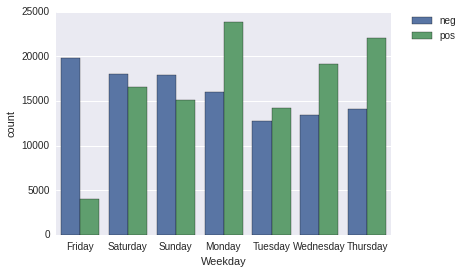

In [1690]:
sns.countplot(x='Weekday', data=X, hue='ttype')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

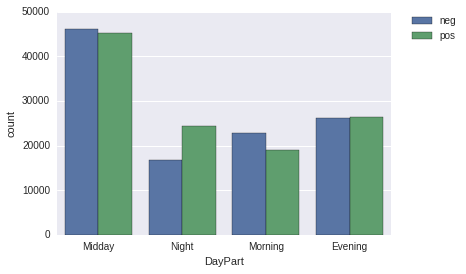

In [1691]:
sns.countplot(x='DayPart', data=X, hue='ttype')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [1495]:
def convert_date(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    h = date.hour
    
#     if h <= 6:
#         d_type = 'Night'
#     elif h <= 12:
#         d_type = 'Morning'
#     elif h <= 18:
#         d_type = 'Midday'
#     else:
#         d_type = 'Evening'
    
    if h >= 23 or h <= 5:
        d_type = 1
    elif h > 5 and h <= 11:
        d_type = 2
    elif h > 11 and h <= 18:
        d_type = 3
    else:
        d_type = 4
    
    return pd.Series({'Weekday':date.weekday(), 'DayPart': d_type})

In [1496]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['id', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

X = pd.concat([pos, neg])

In [1497]:
date_col = X['tdate'].apply(convert_date)

In [1565]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import scipy

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import scale
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

In [1500]:
X = X.drop('tdate', axis=1)

In [1501]:
y = X['ttype']
X_tweets = X['ttext'].apply(replace_answer)

In [1635]:
vectorizer = TfidfVectorizer(min_df = 5, ngram_range = (1, 3),
                             stop_words = stop, tokenizer = tweet_tokenize)

In [1636]:
(X_train, X_test,
    date_train, date_test,
    y_train, y_test) = train_test_split(X_tweets, date_col, y, train_size=0.7)

In [1637]:
%time X_train = vectorizer.fit_transform(X_train)
%time X_test = vectorizer.transform(X_test)

print X_train.shape

CPU times: user 10min 23s, sys: 3.56 s, total: 10min 26s
Wall time: 10min 26s
CPU times: user 4min 19s, sys: 696 ms, total: 4min 20s
Wall time: 4min 19s
(158782, 36613)


In [1638]:
enc = OneHotEncoder()
date_train = enc.fit_transform(date_train)
date_test = enc.transform(date_test)

In [1639]:
X_train = scipy.sparse.hstack([X_train, date_train])
X_test = scipy.sparse.hstack([X_test, date_test])

In [1640]:
#model = SGDClassifier(n_iter=50, loss='modified_huber')
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print accuracy_score(y_test, pred)

In [1641]:
#SVC = 0.84999265246142541
#NB mult = 0.84693607641440116
#NB Bern = 0.85388684790595148
#Linear SVC = 0.84793534166054374

(158782, 36624)